# 뉴스 데이터 수집, 전처리, 감정분석 (Finnhub API) 

In [ ]:
import requests
import pandas as pd
import datetime
import os
from dotenv import load_dotenv
import yfinance as yf
import time

# .env 설정 로드
load_dotenv()
FINHUB_API_KEY = os.getenv("finhub")  # 변수명은 'finnhub' 아닌 'finhub'

# API 호출 제한 (60 calls/minute)
API_CALLS_PER_MINUTE = 60
DELAY_BETWEEN_CALLS = 60.0 / API_CALLS_PER_MINUTE  # 1초 간격


def safe_datetime_conversion(timestamp):
    """
    타임스탬프를 안전하게 datetime으로 변환합니다.
    Out of bounds nanosecond timestamp 오류를 방지합니다.
    """
    if not timestamp or timestamp == 0:
        return None
    
    try:
        # 유닉스 타임스탬프 범위 확인 (1970-01-01 이후)
        if timestamp < 0:
            return None
            
        # 너무 큰 값 확인 (2262년 이후는 pandas에서 처리 불가)
        if timestamp > 9223372036:  # 2262-04-11 정도
            return None
            
        # 정상적인 변환 시도
        return pd.to_datetime(timestamp, unit='s')
        
    except (ValueError, OutOfBoundsDatetime, OverflowError):
        # 변환 실패 시 None 반환
        return None
    except Exception:
        # 기타 예외 시 None 반환
        return None


# Finnhub에서 회사 뉴스 수집 (최적화된 버전 - 대량 수집)
def fetch_finnhub_news_extended(symbol: str = "GOOGL", start_date: str = "2025-06-14", days_per_request: int = 30) -> pd.DataFrame:
    """
    하나의 심볼에 대해 최대한 많은 뉴스를 수집합니다.
    날짜 구간을 나누어서 여러 번 API 호출하여 더 많은 기사를 수집합니다.
    
    Args:
        symbol: 주식 심볼 (예: "AAPL")
        start_date: 시작 날짜 (YYYY-MM-DD)
        days_per_request: 한 번의 API 호출당 수집할 일수 (기본: 30일)
    """
    if not FINHUB_API_KEY:
        print("[ERROR] Finnhub API 키가 설정되지 않았습니다. .env 파일을 확인하세요.")
        return pd.DataFrame()

    url = "https://finnhub.io/api/v1/company-news"
    
    try:
        start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
        today = datetime.date.today()
        
        print(f"[INFO] 요청 시작 날짜: {start_date_obj}")
        print(f"[INFO] 현재 날짜: {today}")
        
        # Free Tier 제한을 넘어서 최대한 많이 수집 시도
        two_years_ago = today - datetime.timedelta(days=730)  # 2년 전
        three_years_ago = today - datetime.timedelta(days=1095)  # 3년 전
        
        print(f"[INFO] 🚀 Free Tier 제한 돌파 시도: 2-3년간 뉴스 수집을 시도합니다!")
        print(f"[INFO] 2년 전 날짜: {two_years_ago}")
        print(f"[INFO] 3년 전 날짜: {three_years_ago}")
        
        # 3년 전부터 현재까지로 시도 (API가 어디까지 허용하는지 테스트)
        actual_start = three_years_ago
        actual_end = today
        
        print(f"[INFO] {symbol} 뉴스 대량 수집 시작 (제한 돌파 시도)")
        print(f"[INFO] 실제 수집 기간: {actual_start.isoformat()} ~ {actual_end.isoformat()}")
        print(f"[INFO] 수집 기간: {(actual_end - actual_start).days}일 (약 3년)")
        print(f"[INFO] 예상 API 호출 횟수: {(actual_end - actual_start).days // days_per_request + 1}회")
        print(f"[WARNING] API가 제한할 수 있습니다. 테스트 중...")
        
    except ValueError:
        print(f"[ERROR] 잘못된 날짜 형식: {start_date}. YYYY-MM-DD 형식을 사용하세요.")
        return pd.DataFrame()

    all_articles = []
    current_date = actual_start
    request_count = 0
    
    while current_date < actual_end:
        # 각 요청의 종료 날짜 계산
        period_end = min(current_date + datetime.timedelta(days=days_per_request), actual_end)
        
        params = {
            "symbol": symbol,
            "from": current_date.isoformat(),
            "to": period_end.isoformat(),
            "token": FINHUB_API_KEY
        }
        
        try:
            request_count += 1
            print(f"[INFO] API 호출 {request_count}: {current_date.isoformat()} ~ {period_end.isoformat()}")
            
            # API 호출 제한을 위한 딜레이
            time.sleep(DELAY_BETWEEN_CALLS)
            
            res = requests.get(url, params=params, timeout=30)
            
            if res.status_code == 429:
                print(f"[WARNING] API 호출 제한 도달. 더 긴 대기 후 재시도...")
                time.sleep(10)
                res = requests.get(url, params=params, timeout=30)
            
            if res.status_code == 403:
                print(f"[ERROR] API 접근 거부 (기간: {current_date} ~ {period_end}): Free Tier 제한 도달 가능성")
                print(f"[INFO] 현재까지 수집된 기사: {len(all_articles)}개")
                break
            
            if res.status_code != 200:
                print(f"[WARNING] API 요청 실패 (기간: {current_date} ~ {period_end}): HTTP {res.status_code}")
                print(f"[INFO] 응답 내용: {res.text[:200]}...")
                
                # 429 (Too Many Requests)가 아니라면 계속 진행
                if res.status_code != 429:
                    current_date = period_end + datetime.timedelta(days=1)
                    continue
                else:
                    print(f"[INFO] 호출 제한으로 인한 대기...")
                    time.sleep(30)
                    continue

            data = res.json()
            
            if not isinstance(data, list):
                print(f"[WARNING] 예상과 다른 응답 형식 (기간: {current_date} ~ {period_end})")
                if isinstance(data, dict) and 'error' in data:
                    print(f"[ERROR] API 오류: {data['error']}")
                    if 'limit' in data['error'].lower():
                        print(f"[INFO] Free Tier 제한 도달. 현재까지 수집: {len(all_articles)}개")
                        break
                current_date = period_end + datetime.timedelta(days=1)
                continue

            # 해당 기간의 뉴스 수집
            period_articles = []
            for item in data:
                # 안전한 datetime 변환 사용
                pub_date = safe_datetime_conversion(item.get("datetime"))
                
                article = {
                    "id": item.get("id"),
                    "title": item.get("headline", ""),
                    "summary": item.get("summary", ""),
                    "link": item.get("url", ""),
                    "publisher": item.get("publisher", ""),
                    "category": item.get("category", ""),
                    "pubDate": pub_date,
                    "image": item.get("image", ""),
                    "related": item.get("related", ""),
                    "source": item.get("source", ""),
                    "collection_period": f"{current_date.isoformat()}_{period_end.isoformat()}"
                }
                period_articles.append(article)
            
            all_articles.extend(period_articles)
            print(f"[SUCCESS] 기간별 수집: {len(period_articles)}개 기사 (총 {len(all_articles)}개)")
            
        except Exception as e:
            print(f"[ERROR] API 호출 오류 (기간: {current_date} ~ {period_end}): {e}")
            if "limit" in str(e).lower() or "403" in str(e):
                print(f"[INFO] Free Tier 제한 도달 가능성. 현재까지 수집: {len(all_articles)}개")
                break
        
        # 다음 기간으로 이동
        current_date = period_end + datetime.timedelta(days=1)
        
        # API 호출 제한 방지를 위한 추가 대기
        if request_count % 10 == 0:  # 10번 호출마다 추가 대기
            print(f"[INFO] API 제한 방지를 위한 대기... (현재까지 {len(all_articles)}개 수집)")
            time.sleep(2)

    # 전체 결과 처리
    if all_articles:
        df = pd.DataFrame(all_articles)
        
        # 중복 제거 (ID, 제목, 링크 기준)
        before_dedup = len(df)
        df = df.drop_duplicates(subset=['id', 'title', 'link'])
        after_dedup = len(df)
        
        if before_dedup != after_dedup:
            print(f"[INFO] 중복 기사 제거: {before_dedup - after_dedup}개")
        
        # 날짜순 정렬 (최신순) - None 값 처리
        df = df.sort_values('pubDate', ascending=False, na_position='last')
        
        print(f"[SUCCESS] {symbol} 총 {len(df)}개의 뉴스 기사 수집 완료!")
        print(f"[INFO] 총 API 호출 횟수: {request_count}회")
        
        return df
    else:
        print(f"[WARNING] {symbol}에 대한 뉴스를 찾을 수 없습니다.")
        return pd.DataFrame()


# yfinance 주가 데이터
def fetch_stock_data(ticker_symbol: str, period: str = '1y', interval: str = '1d') -> pd.DataFrame:
    try:
        df = yf.download(
            tickers=ticker_symbol,
            period=period,
            interval=interval,
            auto_adjust=False,
            progress=False
        )
        if df.empty:
            return pd.DataFrame()
        df = df.reset_index()
        df = df.rename(columns={'Adj Close': 'Adj_Close'})
        return df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]
    except Exception as e:
        print(f"[ERROR] 주식 데이터 오류: {e}")
        return pd.DataFrame()


if __name__ == "__main__":
    # 대량 뉴스 수집할 단일 심볼 설정
    target_symbol = "GOOGL"  # 원하는 심볼로 변경 가능 (예: MSFT, GOOGL, AMZN, TSLA, META, NVDA 등)
    start_date = "2025-06-13"  # 참고용 (실제로는 1년 전부터 자동 수집)
    days_per_request = 7  # 한 번의 API 호출당 7일씩 수집 (더 많은 API 호출로 최대 수집)
    
    print(f"{target_symbol} 뉴스 대량 수집 시작!")
    print(f"참고 날짜: {start_date} (실제로는 3년 전부터 수집 시도)")
    print(f"수집 방식: {days_per_request}일씩 구간별 수집")
    print(f"API 제한: {API_CALLS_PER_MINUTE}회/분")
    print(f"목표:Free Tier 제한 돌파 시도 - 최대 3년간 뉴스 수집!")
    print(f"주의: API가 제한을 걸 수 있으니 실험적 수집입니다.")
    print("="*60)
    
    # 확장된 뉴스 수집 함수 사용
    df_extended_news = fetch_finnhub_news_extended(
        symbol=target_symbol, 
        start_date=start_date,
        days_per_request=days_per_request
    )
    
    if not df_extended_news.empty:
        print(f"\n🎉 {target_symbol} 뉴스 수집 완료!")
        print(f"📰 총 수집 기사 수: {len(df_extended_news)}개")
        
        # 날짜별 기사 분포 분석 (유효한 날짜만)
        if 'pubDate' in df_extended_news.columns:
            valid_dates = df_extended_news[df_extended_news['pubDate'].notna()].copy()
            if not valid_dates.empty:
                valid_dates['date_only'] = valid_dates['pubDate'].dt.date
                date_counts = valid_dates['date_only'].value_counts().sort_index()
                print(f"📈 수집 기간: {date_counts.index.min()} ~ {date_counts.index.max()}")
                print(f"📊 평균 일일 기사 수: {date_counts.mean():.1f}개")
                print(f"📅 유효한 날짜 기사: {len(valid_dates)}개 / 전체 {len(df_extended_news)}개")
        
        # 최신 기사 10개 미리보기
        print(f"\n📰 최신 뉴스 미리보기 (상위 10개)")
        print("-" * 80)
        for i, row in df_extended_news.head(10).iterrows():
            pub_date = row['pubDate'].strftime('%Y-%m-%d %H:%M') if pd.notna(row['pubDate']) else 'N/A'
            title = row['title'][:60] + "..." if len(row['title']) > 60 else row['title']
            publisher = row['publisher'] if row['publisher'] else row['source']
            print(f"{i+1:2d}. [{publisher}] {title}")
            print(f"    📅 {pub_date} | 🔗 {row['link'][:50]}...")
            print()
        
        # CSV 파일로 저장
        today = datetime.date.today().isoformat()
        filename = f"{target_symbol}_extended_news_{today}.csv"
        df_extended_news.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"💾 파일 저장 완료: {filename}")
        
        # 발행처별 통계
        print(f"\n📊 발행처별 기사 수 통계 (상위 10개)")
        print("-" * 40)
        publisher_col = 'publisher' if df_extended_news['publisher'].notna().any() else 'source'
        publisher_counts = df_extended_news[publisher_col].value_counts()
        for publisher, count in publisher_counts.head(10).items():
            if publisher:  # 빈 값이 아닌 경우만
                print(f"{publisher:25s}: {count:3d}개")
        
        # 카테고리별 통계 (있는 경우)
        if 'category' in df_extended_news.columns and df_extended_news['category'].notna().any():
            print(f"\n🏷️  카테고리별 기사 수")
            print("-" * 30)
            category_counts = df_extended_news['category'].value_counts()
            for category, count in category_counts.items():
                if category:
                    print(f"{category:20s}: {count:3d}개")
                    
    else:
        print(f"❌ {target_symbol} 뉴스 수집에 실패했습니다.")
        print("🔧 가능한 해결 방법:")
        print("   1. API 키 확인 (.env 파일의 'finhub' 변수)")
        print("   2. 인터넷 연결 확인")  
        print("   3. 심볼명 확인 (미국 상장 기업만 지원)")
        print("   4. 날짜 범위 조정")
    
    print("\n" + "="*60)
    print("📋 수집 완료 요약")
    print("="*60)
    print(f"🏢 대상 기업: {target_symbol}")
    print(f"📅 수집 날짜: {start_date}")
    print(f"📊 총 기사 수: {len(df_extended_news) if not df_extended_news.empty else 0}개")
    print(f"💾 저장 파일: {filename if not df_extended_news.empty else 'N/A'}")


# Y finance

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import warnings
import numpy as np
warnings.filterwarnings('ignore')

def get_hourly_stock_data(ticker, days=365, save_to_csv=True):
    """
    티커를 입력받아 최근 N일간의 1시간 간격 주식 데이터를 가져오는 함수
    
    Parameters:
    ticker (str): 주식 티커 심볼 (예: 'AAPL', 'TSLA', 'AMZN')
    days (int): 수집할 일수 (최대 730일, yfinance 제약)
    save_to_csv (bool): CSV 파일로 저장할지 여부
    
    Returns:
    pandas.DataFrame: 1시간 간격 주식 데이터
    """
    
    try:
        # yfinance 1시간 간격 제약사항 확인
        if days > 730:
            print(f"⚠️ yfinance 1시간 간격 데이터는 최대 730일까지만 지원됩니다.")
            print(f"요청한 {days}일 → 730일로 조정합니다.")
            days = 730
        
        # 날짜 설정 (현재 날짜 기준)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        print(f"📊 {ticker} 주식 데이터 수집 중...")
        print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')} ({days}일)")
        print(f"간격: 1시간")
        
        # yfinance로 데이터 수집 (24시간 데이터 포함)
        stock_data = yf.download(
            ticker,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            interval='1h',
            prepost=True,  # 시장 외 시간 데이터 포함
            progress=False
        )
        
        if stock_data.empty:
            print(f"❌ {ticker}에 대한 데이터를 찾을 수 없습니다.")
            return None
        
        # 인덱스를 컬럼으로 변환
        stock_data = stock_data.reset_index()
        
        # 컬럼명 확인 및 정리
        print(f"🔍 원본 컬럼명: {list(stock_data.columns)}")
        
        # 인덱스 컬럼명 통일 (Datetime으로)
        if 'Date' in stock_data.columns:
            stock_data = stock_data.rename(columns={'Date': 'Datetime'})
        elif stock_data.columns[0] not in ['Datetime', 'Date']:
            # 첫 번째 컬럼이 시간 데이터인 경우
            stock_data = stock_data.rename(columns={stock_data.columns[0]: 'Datetime'})
        
        # 멀티레벨 컬럼인 경우 처리
        if isinstance(stock_data.columns, pd.MultiIndex):
            new_columns = []
            for col in stock_data.columns:
                if isinstance(col, tuple):
                    if col[0] == 'Datetime' or 'Date' in str(col[0]):
                        new_columns.append('Datetime')
                    else:
                        new_columns.append(col[0])
                else:
                    new_columns.append(col)
            stock_data.columns = new_columns
        
        # 기본 정보 출력
        print(f"✅ 데이터 수집 완료!")
        print(f"총 데이터 포인트: {len(stock_data):,}개")
        print(f"정리된 컬럼명: {list(stock_data.columns)}")
        
        # Datetime 컬럼 확인
        if 'Datetime' in stock_data.columns:
            print(f"데이터 기간: {stock_data['Datetime'].min()} ~ {stock_data['Datetime'].max()}")
        else:
            print(f"⚠️ Datetime 컬럼을 찾을 수 없습니다. 첫 번째 컬럼 사용: {stock_data.columns[0]}")
            stock_data = stock_data.rename(columns={stock_data.columns[0]: 'Datetime'})
        
        # 기본 통계
        print(f"\n📈 기본 통계:")
        print(f"시작 가격: ${stock_data['Open'].iloc[0]:.2f}")
        print(f"종료 가격: ${stock_data['Close'].iloc[-1]:.2f}")
        print(f"최고가: ${stock_data['High'].max():.2f}")
        print(f"최저가: ${stock_data['Low'].min():.2f}")
        print(f"평균 거래량: {stock_data['Volume'].mean():,.0f}")
        
        # 시간을 정시로 조정 (예: 13:30 -> 13:00)
        stock_data = adjust_time_to_hour(stock_data)
        
        # 추가 특성 계산
        stock_data = add_technical_features(stock_data)
        
        # CSV 저장
        if save_to_csv:
            filename = f"{ticker}_1hour_data_{days}days.csv"
            stock_data.to_csv(filename, index=False)
            print(f"💾 데이터가 '{filename}'에 저장되었습니다.")
        
        return stock_data
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print(f"오류 상세: {type(e).__name__}")
        return None

def get_30min_stock_data(ticker, days=60, save_to_csv=True):
    """
    티커를 입력받아 최근 N일간의 30분 간격 주식 데이터를 가져오는 함수
    
    Parameters:
    ticker (str): 주식 티커 심볼 (예: 'AAPL', 'TSLA', 'AMZN')
    days (int): 수집할 일수 (최대 60일, yfinance 제약)
    save_to_csv (bool): CSV 파일로 저장할지 여부
    
    Returns:
    pandas.DataFrame: 30분 간격 주식 데이터
    """
    
    try:
        # yfinance 30분 간격 제약사항 확인
        if days > 60:
            print(f"⚠️ yfinance 30분 간격 데이터는 최대 60일까지만 지원됩니다.")
            print(f"요청한 {days}일 → 60일로 조정합니다.")
            days = 60
        
        # 날짜 설정 (현재 날짜 기준)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        print(f"📊 {ticker} 주식 데이터 수집 중...")
        print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')} ({days}일)")
        print(f"간격: 30분")
        
        # yfinance로 데이터 수집 (24시간 데이터 포함)
        stock_data = yf.download(
            ticker,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            interval='30m',
            prepost=True,  # 시장 외 시간 데이터 포함
            progress=False
        )
        
        if stock_data.empty:
            print(f"❌ {ticker}에 대한 데이터를 찾을 수 없습니다.")
            return None
        
        # 인덱스를 컬럼으로 변환
        stock_data = stock_data.reset_index()
        
        # 컬럼명 확인 및 정리
        print(f"🔍 원본 컬럼명: {list(stock_data.columns)}")
        
        # 인덱스 컬럼명 통일 (Datetime으로)
        if 'Date' in stock_data.columns:
            stock_data = stock_data.rename(columns={'Date': 'Datetime'})
        elif stock_data.columns[0] not in ['Datetime', 'Date']:
            # 첫 번째 컬럼이 시간 데이터인 경우
            stock_data = stock_data.rename(columns={stock_data.columns[0]: 'Datetime'})
        
        # 멀티레벨 컬럼인 경우 처리
        if isinstance(stock_data.columns, pd.MultiIndex):
            new_columns = []
            for col in stock_data.columns:
                if isinstance(col, tuple):
                    if col[0] == 'Datetime' or 'Date' in str(col[0]):
                        new_columns.append('Datetime')
                    else:
                        new_columns.append(col[0])
                else:
                    new_columns.append(col)
            stock_data.columns = new_columns
        
        # 기본 정보 출력
        print(f"✅ 데이터 수집 완료!")
        print(f"총 데이터 포인트: {len(stock_data):,}개")
        print(f"정리된 컬럼명: {list(stock_data.columns)}")
        
        # Datetime 컬럼 확인
        if 'Datetime' in stock_data.columns:
            print(f"데이터 기간: {stock_data['Datetime'].min()} ~ {stock_data['Datetime'].max()}")
        else:
            print(f"⚠️ Datetime 컬럼을 찾을 수 없습니다. 첫 번째 컬럼 사용: {stock_data.columns[0]}")
            stock_data = stock_data.rename(columns={stock_data.columns[0]: 'Datetime'})
        
        # 기본 통계
        print(f"\n📈 기본 통계:")
        print(f"시작 가격: ${stock_data['Open'].iloc[0]:.2f}")
        print(f"종료 가격: ${stock_data['Close'].iloc[-1]:.2f}")
        print(f"최고가: ${stock_data['High'].max():.2f}")
        print(f"최저가: ${stock_data['Low'].min():.2f}")
        print(f"평균 거래량: {stock_data['Volume'].mean():,.0f}")
        
        # 시간을 정시로 조정 (예: 13:30 -> 13:00)
        stock_data = adjust_time_to_hour(stock_data)
        
        # 추가 특성 계산
        stock_data = add_technical_features(stock_data)
        
        # CSV 저장
        if save_to_csv:
            filename = f"{ticker}_30min_data_{days}days.csv"
            stock_data.to_csv(filename, index=False)
            print(f"💾 데이터가 '{filename}'에 저장되었습니다.")
        
        return stock_data
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print(f"오류 상세: {type(e).__name__}")
        return None

def get_max_period_data(ticker, save_to_csv=True):
    """
    yfinance 제약사항에 맞춰 가능한 최대 기간의 데이터를 수집
    - 1시간: 730일 (약 2년)
    - 30분: 60일
    - 15분: 60일
    - 5분: 60일
    - 1분: 7일
    """
    
    print(f"🚀 {ticker} 최대 기간 데이터 수집...")
    
    intervals_and_periods = [
        ('1h', 730, '2년'),
        ('30m', 60, '60일'),
        ('15m', 60, '60일'),
        ('5m', 60, '60일'),
        ('1m', 7, '7일')
    ]
    
    all_data = {}
    
    for interval, max_days, description in intervals_and_periods:
        try:
            print(f"\n📊 {interval} 간격 데이터 수집 중... (최대 {description})")
            
            end_date = datetime.now()
            start_date = end_date - timedelta(days=max_days)
            
            data = yf.download(
                ticker,
                start=start_date.strftime('%Y-%m-%d'),
                end=end_date.strftime('%Y-%m-%d'),
                interval=interval,
                prepost=True,  # 시장 외 시간 데이터 포함
                progress=False
            )
            
            if not data.empty:
                data = data.reset_index()
                all_data[interval] = data
                print(f"✅ {interval} 데이터: {len(data):,}개 포인트")
                
                if save_to_csv:
                    filename = f"{ticker}_{interval}_data_{max_days}days.csv"
                    data.to_csv(filename, index=False)
                    print(f"💾 저장: {filename}")
            else:
                print(f"❌ {interval} 데이터 없음")
                
        except Exception as e:
            print(f"❌ {interval} 오류: {e}")
    
    return all_data

def get_longer_period_with_daily(ticker, days=365, save_to_csv=True):
    """
    1년 데이터가 필요한 경우 일별 데이터로 수집
    """
    
    try:
        print(f"📊 {ticker} 일별 데이터 수집 중... ({days}일)")
        
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        # 일별 데이터는 제약이 거의 없음
        daily_data = yf.download(
            ticker,
            start=start_date.strftime('%Y-%m-%d'),
            end=end_date.strftime('%Y-%m-%d'),
            interval='1d',
            prepost=True,  # 시장 외 시간 데이터 포함
            progress=False
        )
        
        if daily_data.empty:
            print(f"❌ {ticker} 일별 데이터를 찾을 수 없습니다.")
            return None
        
        daily_data = daily_data.reset_index()
        
        print(f"✅ 일별 데이터 수집 완료!")
        print(f"총 데이터 포인트: {len(daily_data):,}개")
        print(f"데이터 기간: {daily_data['Date'].min()} ~ {daily_data['Date'].max()}")
        
        # 기술적 지표 추가
        daily_data = add_technical_features_daily(daily_data)
        
        if save_to_csv:
            filename = f"{ticker}_daily_data_{days}days.csv"
            daily_data.to_csv(filename, index=False)
            print(f"💾 데이터가 '{filename}'에 저장되었습니다.")
        
        return daily_data
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

def add_technical_features_daily(df):
    """일별 데이터용 기술적 지표 추가"""
    
    print("🔧 기술적 지표 계산 중...")
    
    # 수익률 계산
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 이동평균
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 지수이동평균
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Close'].ewm(span=26).mean()
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # RSI
    df['RSI'] = calculate_rsi(df['Close'])
    
    # 볼린저 밴드
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # 변동성
    df['Volatility_5'] = df['Returns'].rolling(window=5).std()
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    
    # 가격 변화
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    
    # High-Low 스프레드
    df['HL_Spread'] = df['High'] - df['Low']
    df['HL_Spread_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
    
    # 시간 특성 (일별 데이터용)
    df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter
    df['DayOfMonth'] = pd.to_datetime(df['Date']).dt.day
    df['WeekOfYear'] = pd.to_datetime(df['Date']).dt.isocalendar().week
    
    # 거래일 특성
    df['Is_Monday'] = (df['DayOfWeek'] == 0).astype(int)
    df['Is_Friday'] = (df['DayOfWeek'] == 4).astype(int)
    df['Is_MonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)
    df['Is_MonthStart'] = pd.to_datetime(df['Date']).dt.is_month_start.astype(int)
    
    print(f"✅ 기술적 지표 추가 완료! 총 컬럼 수: {len(df.columns)}개")
    
    return df

def add_technical_features(df):
    """기술적 지표 추가"""
    
    print("🔧 기술적 지표 계산 중...")
    
    # 수익률 계산
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 이동평균
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 지수이동평균
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Close'].ewm(span=26).mean()
    
    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # RSI
    df['RSI'] = calculate_rsi(df['Close'])
    
    # 볼린저 밴드
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # 변동성
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    
    # 가격 변화
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    
    # High-Low 스프레드
    df['HL_Spread'] = df['High'] - df['Low']
    df['HL_Spread_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
    
    # 시간 특성
    df['Hour'] = df['Datetime'].dt.hour
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek
    df['Month'] = df['Datetime'].dt.month
    df['Quarter'] = df['Datetime'].dt.quarter
    
    # 거래시간 여부 (미국 주식시장: 9:30-16:00 EST, 24시간 포함으로 확대)
    df['Is_Trading_Hours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 16)).astype(int)  # 정규 거래시간
    df['Is_Market_Open'] = ((df['Hour'] >= 9) & (df['Hour'] < 16)).astype(int)     # 시장 개장시간
    df['Is_Premarket'] = ((df['Hour'] >= 4) & (df['Hour'] < 9)).astype(int)       # 프리마켓 (4:00-9:30)
    df['Is_Aftermarket'] = ((df['Hour'] >= 16) & (df['Hour'] <= 20)).astype(int)  # 애프터마켓 (16:00-20:00)
    df['Is_Extended_Hours'] = (df['Is_Premarket'] | df['Is_Aftermarket']).astype(int)  # 연장거래시간
    
    print(f"✅ 기술적 지표 추가 완료! 총 컬럼 수: {len(df.columns)}개")
    
    return df

def calculate_rsi(prices, window=14):
    """RSI (Relative Strength Index) 계산"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def adjust_time_to_hour(df):
    """시간을 정시로 조정하는 함수 (예: 13:30 -> 13:00)"""
    
    print("🕐 시간을 정시로 조정 중...")
    
    # Datetime 컬럼이 있는지 확인
    if 'Datetime' in df.columns:
        # 시간을 정시로 조정 (분, 초를 0으로 설정)
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df['Datetime'] = df['Datetime'].dt.floor('H')  # 시간 단위로 내림
        
        print(f"✅ 시간 조정 완료: {df['Datetime'].min()} ~ {df['Datetime'].max()}")
        
        # 중복된 시간이 있는 경우 마지막 값 유지
        df = df.drop_duplicates(subset=['Datetime'], keep='last')
        print(f"중복 제거 후 데이터 포인트: {len(df):,}개")
        
    return df

def get_multiple_tickers_hourly(tickers, days=365, save_individual=True, save_combined=True):
    """여러 티커의 1시간 간격 데이터를 한번에 수집"""
    
    print(f"🚀 {len(tickers)}개 티커 1시간 간격 데이터 수집 시작...")
    print(f"티커 목록: {', '.join(tickers)}")
    print(f"수집 기간: 최근 {days}일")
    print("=" * 60)
    
    all_data = {}
    
    for i, ticker in enumerate(tickers, 1):
        print(f"\n[{i}/{len(tickers)}] {ticker} 처리 중...")
        
        data = get_hourly_stock_data(ticker, days=days, save_to_csv=save_individual)
        
        if data is not None:
            all_data[ticker] = data
            print(f"✅ {ticker} 완료")
        else:
            print(f"❌ {ticker} 실패")
        
        print("-" * 40)
    
    # 통합 데이터 저장
    if save_combined and all_data:
        print(f"\n💾 통합 데이터 저장 중...")
        
        # 각 티커별로 컬럼에 티커명 추가
        combined_data = pd.DataFrame()
        
        for ticker, data in all_data.items():
            ticker_data = data.copy()
            ticker_data['Ticker'] = ticker
            combined_data = pd.concat([combined_data, ticker_data], ignore_index=True)
        
        combined_filename = f"multiple_stocks_1hour_data_{days}days.csv"
        combined_data.to_csv(combined_filename, index=False)
        print(f"✅ 통합 데이터가 '{combined_filename}'에 저장되었습니다.")
        print(f"총 데이터 포인트: {len(combined_data):,}개")
    
    return all_data

def get_multiple_tickers(tickers, days=60, save_individual=True, save_combined=True):
    """여러 티커의 30분 간격 데이터를 한번에 수집"""
    
    print(f"🚀 {len(tickers)}개 티커 30분 간격 데이터 수집 시작...")
    print(f"티커 목록: {', '.join(tickers)}")
    print(f"수집 기간: 최근 {days}일")
    print("=" * 60)
    
    all_data = {}
    
    for i, ticker in enumerate(tickers, 1):
        print(f"\n[{i}/{len(tickers)}] {ticker} 처리 중...")
        
        data = get_30min_stock_data(ticker, days=days, save_to_csv=save_individual)
        
        if data is not None:
            all_data[ticker] = data
            print(f"✅ {ticker} 완료")
        else:
            print(f"❌ {ticker} 실패")
        
        print("-" * 40)
    
    # 통합 데이터 저장
    if save_combined and all_data:
        print(f"\n💾 통합 데이터 저장 중...")
        
        # 각 티커별로 컬럼에 티커명 추가
        combined_data = pd.DataFrame()
        
        for ticker, data in all_data.items():
            ticker_data = data.copy()
            ticker_data['Ticker'] = ticker
            combined_data = pd.concat([combined_data, ticker_data], ignore_index=True)
        
        combined_filename = f"multiple_stocks_30min_data_{days}days.csv"
        combined_data.to_csv(combined_filename, index=False)
        print(f"✅ 통합 데이터가 '{combined_filename}'에 저장되었습니다.")
        print(f"총 데이터 포인트: {len(combined_data):,}개")
    
    return all_data

def analyze_data_summary(data_dict):
    """수집된 데이터 요약 분석"""
    
    print("\n" + "=" * 60)
    print("📊 데이터 수집 요약")
    print("=" * 60)
    
    for ticker, data in data_dict.items():
        if data is not None:
            print(f"\n{ticker}:")
            print(f"  데이터 포인트: {len(data):,}개")
            print(f"  기간: {data['Datetime'].min().strftime('%Y-%m-%d %H:%M')} ~ {data['Datetime'].max().strftime('%Y-%m-%d %H:%M')}")
            print(f"  가격 범위: ${data['Low'].min():.2f} ~ ${data['High'].max():.2f}")
            print(f"  평균 거래량: {data['Volume'].mean():,.0f}")
            
            # 결측치 확인
            missing_count = data.isnull().sum().sum()
            if missing_count > 0:
                print(f"  ⚠️ 결측치: {missing_count}개")
            else:
                print(f"  ✅ 결측치 없음")

# 사용 예시
if __name__ == "__main__":
    
    print("🎯 yfinance 제약사항 안내:")
    print("- 1시간 간격: 최대 730일 (약 2년) ⭐ 추천!")
    print("- 30분 간격: 최대 60일")
    print("- 일별 간격: 제한 없음")
    print("=" * 60)
    
    # 1. 1시간 간격 데이터 (1년) - 메인 추천!
    print("\n🎯 1시간 간격 데이터 수집 (1년) - 추천!")
    aapl_1h = get_hourly_stock_data('AAPL', days=365)
    
    if aapl_1h is not None:
        print(f"\n📋 AAPL 1시간 데이터 미리보기:")
        print(aapl_1h[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']].head())
        
        # 데이터 양 분석
        trading_hours = aapl_1h[aapl_1h['Is_Trading_Hours'] == 1]
        print(f"\n📊 LSTM 학습용 데이터 분석:")
        print(f"전체 시간: {len(aapl_1h):,}개")
        print(f"거래시간만: {len(trading_hours):,}개")
        print(f"LSTM 시퀀스 길이 30 가정 시 학습 샘플: {len(trading_hours) - 30:,}개")
    
    print("\n" + "="*80)
    
    # 2. 여러 티커 1시간 데이터 (1년)
    print("\n🎯 여러 티커 1시간 데이터 수집 (1년)")
    tickers = ['AAPL', 'AMZN', 'TSLA', 'GOOGL', 'MSFT']
    
    all_stock_data = get_multiple_tickers_hourly(tickers, days=365)
    
    # 3. 요약 분석
    analyze_data_summary(all_stock_data)
    
    print("\n" + "="*80)
    
    # 4. 30분 간격 비교용 (60일)
    print("\n🎯 30분 간격 데이터 비교 (60일)")
    print("⚠️ 30분 간격은 최대 60일 제한이 있습니다.")
    
    # 현재 날짜 확인
    current_date = datetime.now()
    print(f"현재 날짜: {current_date.strftime('%Y-%m-%d')}")
    
    aapl_30m = get_30min_stock_data('AAPL', days=30)  # 30일로 줄여서 안전하게 테스트
    
    if aapl_30m is not None:
        print(f"\n📋 AAPL 30분 데이터 미리보기:")
        print(aapl_30m[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']].head())
    
    print("\n🎉 모든 데이터 수집 완료!")
    print("\n💡 권장사항:")
    print("✅ 1시간 간격 1년 데이터 - LSTM 학습에 최적!")
    print(f"   → 약 {365 * 6.5:.0f}개 거래시간 데이터 포인트")
    print("   → 충분한 데이터 양 + 적절한 시간 해상도")
    print("⚠️ 30분 간격은 60일 제한으로 데이터 부족")
    print("⚠️ 일별 데이터는 시간 해상도 부족")


# rapid api

In [ ]:
#!/usr/bin/env python3
"""
RapidAPI - twitter241 엔드포인트를 사용한 트윗 크롤러
"""

import requests
import json
import csv
import os
import time
import logging
from datetime import datetime
from typing import List, Dict, Optional, Any

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('rapidapi_crawler.log', encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

class RapidAPITweetCrawler:
    """
    RapidAPI의 twitter241 엔드포인트를 사용하여 트윗을 수집하고 CSV로 저장하는 크롤러.
    페이지네이션(cursor)을 처리하여 지정된 개수만큼 트윗을 수집합니다.
    """
    def __init__(self, api_key: str):
        """
        크롤러를 초기화합니다.
        
        Args:
            api_key: RapidAPI에서 발급받은 API 키
        """
        if not api_key:
            raise ValueError("API 키가 제공되지 않았습니다.")
            
        self.api_key = api_key
        self.base_url = "https://twitter241.p.rapidapi.com/user-tweets"
        self.headers = {
            "x-rapidapi-key": self.api_key,
            "x-rapidapi-host": "twitter241.p.rapidapi.com"
        }
        # count를 증가시켜 한번에 더 많은 트윗 요청 (최대 200까지 시도)
        self.count_per_request = 200
        
        # cursor 캐시 및 중복 방지
        self.used_cursors = set()

    def _parse_tweets_from_response(self, response_json: Dict[str, Any]) -> List[Dict[str, str]]:
        """
        API 응답 JSON에서 트윗 데이터를 파싱합니다.
        
        Args:
            response_json: API로부터 받은 JSON 응답
        
        Returns:
            추출된 트윗 데이터 리스트 ({'created_at': ..., 'full_text': ...})
        """
        tweets_data = []
        
        try:
            # 'instructions' 리스트에서 'TimelineAddEntries' 타입의 항목을 찾습니다.
            instructions = response_json.get('result', {}).get('timeline', {}).get('instructions', [])
            
            timeline_entries = []
            for instruction in instructions:
                if instruction.get('type') == 'TimelineAddEntries':
                    timeline_entries = instruction.get('entries', [])
                    break
            
            if not timeline_entries:
                logger.warning("응답에서 'entries'를 찾을 수 없습니다.")
                return []

            for entry in timeline_entries:
                # 'TimelineTweet' 타입의 콘텐츠만 처리
                item_content = entry.get('content', {}).get('itemContent', {})
                if item_content and item_content.get('itemType') == 'TimelineTweet':
                    tweet_results = item_content.get('tweet_results', {})
                    result = tweet_results.get('result', {})
                    
                    # legacy 필드에 실제 데이터가 있습니다.
                    legacy_data = result.get('legacy', {})
                    
                    if legacy_data:
                        created_at = legacy_data.get('created_at', 'N/A')
                        full_text = ""
                        
                        # 리트윗(RT)인 경우 원본 트윗의 full_text를 가져옵니다.
                        # 'retweeted_status_result' 키가 있는지 확인합니다.
                        if 'retweeted_status_result' in legacy_data:
                            # 원본 트윗의 legacy 데이터를 찾습니다.
                            original_tweet_legacy = legacy_data.get('retweeted_status_result', {}).get('result', {}).get('legacy', {})
                            full_text = original_tweet_legacy.get('full_text', '')
                        else:
                            # 일반 트윗은 기존 방식대로 full_text를 가져옵니다.
                            full_text = legacy_data.get('full_text', '')

                        # 줄바꿈 문자를 공백으로 변환하고 양 끝 공백 제거
                        full_text = full_text.replace('\n', ' ').strip()
                        
                        tweets_data.append({
                            'created_at': created_at,
                            'full_text': full_text
                        })
        except (AttributeError, KeyError, IndexError) as e:
            logger.error(f"트윗 데이터 파싱 중 오류 발생: {e}")
            logger.debug(f"오류 발생 지점의 JSON 구조: {json.dumps(response_json, indent=2, ensure_ascii=False)}")
            
        return tweets_data

    def _find_next_cursor(self, response_json: Dict[str, Any]) -> Optional[str]:
        """
        API 응답에서 다음 페이지를 위한 cursor 값을 찾습니다.
        개선된 cursor 파싱으로 더 많은 cursor 타입을 처리합니다.
        
        Args:
            response_json: API로부터 받은 JSON 응답
            
        Returns:
            다음 페이지 cursor 문자열 또는 None
        """
        try:
            instructions = response_json.get('result', {}).get('timeline', {}).get('instructions', [])
            
            # 모든 instruction 타입에서 cursor 찾기
            all_cursors = []
            
            for instruction in instructions:
                # TimelineAddEntries에서 cursor 찾기
                if instruction.get('type') == 'TimelineAddEntries':
                    entries = instruction.get('entries', [])
                    for entry in entries:
                        content = entry.get('content', {})
                        if content.get('entryType') == 'TimelineTimelineCursor':
                            cursor_value = content.get('value')
                            cursor_type = content.get('cursorType', '')
                            
                            if cursor_value and cursor_value not in self.used_cursors:
                                all_cursors.append({
                                    'value': cursor_value,
                                    'type': cursor_type,
                                    'priority': 1 if cursor_type == 'Bottom' else 2
                                })
                
                # TimelineReplaceEntry에서도 cursor 찾기
                elif instruction.get('type') == 'TimelineReplaceEntry':
                    entry = instruction.get('entry', {})
                    content = entry.get('content', {})
                    if content.get('entryType') == 'TimelineTimelineCursor':
                        cursor_value = content.get('value')
                        cursor_type = content.get('cursorType', '')
                        
                        if cursor_value and cursor_value not in self.used_cursors:
                            all_cursors.append({
                                'value': cursor_value,
                                'type': cursor_type,
                                'priority': 1 if cursor_type == 'Bottom' else 2
                            })
            
            # cursor를 우선순위에 따라 정렬 (Bottom이 우선)
            if all_cursors:
                all_cursors.sort(key=lambda x: x['priority'])
                selected_cursor = all_cursors[0]['value']
                self.used_cursors.add(selected_cursor)
                logger.debug(f"선택된 cursor: {selected_cursor[:50]}... (타입: {all_cursors[0]['type']})")
                return selected_cursor
                
        except (AttributeError, KeyError, IndexError) as e:
            logger.error(f"Cursor 파싱 중 오류 발생: {e}")
            
        return None

    def fetch_user_tweets(self, user_id: str, max_tweets: int = 1000):
        """
        특정 사용자의 트윗을 수집하여 CSV 파일로 저장합니다.
        개선된 페이지네이션으로 더 많은 트윗을 효율적으로 수집합니다.
        
        Args:
            user_id: 트윗을 수집할 사용자의 ID
            max_tweets: 수집할 최대 트윗 수
        """
        logger.info(f"사용자 ID {user_id}의 트윗 수집을 시작합니다. 목표: {max_tweets}개")
        logger.info(f"한 번의 요청당 {self.count_per_request}개 트윗 요청")
        
        all_tweets = []
        cursor = None
        request_count = 0
        max_requests = 100  # 무한 루프 방지
        consecutive_empty_responses = 0
        
        # cursor 캐시 초기화
        self.used_cursors.clear()
        
        while len(all_tweets) < max_tweets and request_count < max_requests:
            # count를 동적으로 조정 (남은 트윗 수에 따라)
            remaining_tweets = max_tweets - len(all_tweets)
            current_count = min(self.count_per_request, remaining_tweets)
            
            querystring = {
                "user": user_id,
                "count": str(current_count)
            }
            if cursor:
                querystring["cursor"] = cursor
            
            logger.info(f"API 요청 #{request_count + 1}: {len(all_tweets)} / {max_tweets} 수집됨. Count: {current_count}")
            
            try:
                response = requests.get(self.base_url, headers=self.headers, params=querystring, timeout=45)
                request_count += 1
                
                if response.status_code == 429:  # Rate limit
                    logger.warning("Rate limit에 도달했습니다. 60초 대기...")
                    time.sleep(60)
                    continue
                elif response.status_code != 200:
                    logger.error(f"API 에러: {response.status_code} - {response.text}")
                    if response.status_code >= 500:  # 서버 에러인 경우 재시도
                        logger.info("서버 에러로 인한 10초 후 재시도...")
                        time.sleep(10)
                        continue
                    else:
                        break
                    
                data = response.json()
                
                newly_fetched_tweets = self._parse_tweets_from_response(data)
                
                if not newly_fetched_tweets:
                    consecutive_empty_responses += 1
                    logger.warning(f"이번 응답에서 트윗을 찾을 수 없습니다. ({consecutive_empty_responses}/3)")
                    
                    if consecutive_empty_responses >= 3:
                        logger.info("연속 3회 빈 응답으로 수집을 종료합니다.")
                        break
                else:
                    consecutive_empty_responses = 0
                    logger.info(f"이번 요청에서 {len(newly_fetched_tweets)}개 트윗 수집")
                
                all_tweets.extend(newly_fetched_tweets)
                
                # 중복 제거 (created_at + full_text 기준)
                seen = set()
                unique_tweets = []
                for tweet in all_tweets:
                    tweet_key = (tweet['created_at'], tweet['full_text'])
                    if tweet_key not in seen:
                        seen.add(tweet_key)
                        unique_tweets.append(tweet)
                
                all_tweets = unique_tweets
                logger.info(f"중복 제거 후: {len(all_tweets)}개 트윗")
                
                # 다음 cursor 찾기
                next_cursor = self._find_next_cursor(data)
                if not next_cursor or next_cursor == cursor:
                    logger.info("더 이상 사용 가능한 cursor가 없습니다. 수집을 종료합니다.")
                    break
                
                cursor = next_cursor

                # API rate limit를 고려한 대기 시간 (요청 수에 따라 조정)
                if request_count % 10 == 0:  # 10번째마다 긴 대기
                    wait_time = 5
                else:
                    wait_time = 1
                    
                logger.debug(f"{wait_time}초 대기 중...")
                time.sleep(wait_time)

            except requests.exceptions.Timeout:
                logger.warning("요청 타임아웃. 5초 후 재시도...")
                time.sleep(5)
                continue
            except requests.exceptions.RequestException as e:
                logger.error(f"네트워크 오류 발생: {e}")
                time.sleep(10)
                continue
            except json.JSONDecodeError:
                logger.error("JSON 디코딩 오류. 응답이 올바른 JSON 형식이 아닙니다.")
                time.sleep(5)
                continue

        logger.info(f"총 {len(all_tweets)}개의 트윗을 {request_count}번의 요청으로 수집했습니다.")
        logger.info(f"평균 요청당 트윗 수: {len(all_tweets) / request_count if request_count > 0 else 0:.1f}개")
        
        if all_tweets:
            filename = f"user_{user_id}_tweets_ReTweet.csv"
            self._save_to_csv(all_tweets, filename)
            
    def _save_to_csv(self, tweets_list: List[Dict[str, str]], filename: str):
        """
        수집된 트윗 데이터를 CSV 파일로 저장합니다.
        
        Args:
            tweets_list: 저장할 트윗 데이터 리스트
            filename: 저장할 파일 이름
        """
        try:
            with open(filename, 'w', newline='', encoding='utf-8-sig') as f:
                # 'utf-8-sig'는 Excel에서 한글이 깨지지 않도록 BOM을 추가합니다.
                writer = csv.DictWriter(f, fieldnames=['created_at', 'full_text'])
                writer.writeheader()
                writer.writerows(tweets_list)
            logger.info(f"CSV 파일 저장 완료: {filename}")
        except IOError as e:
            logger.error(f"파일 저장 중 오류 발생: {e}")

def main():
    """
    스크립트 실행을 위한 메인 함수
    """
    print("=" * 70)
    print("  RapidAPI(twitter241) 기반 트윗 크롤러 (개선된 버전)")
    print("=" * 70)
    
    # --- 설정 ---
    # 보안을 위해 API 키는 환경 변수에서 가져오는 것을 권장합니다.
    # 예: api_key = os.getenv("RAPIDAPI_KEY")
    API_KEY = "5fac920861msh988e449f8d91b60p10459bjsnba691d3d2d81" # 사용자 요청에 따라 하드코딩
    USER_ID = "86437069"
    # @WhiteHouse 1879644163769335808
    # @SecScottBessent 1889019333960998912
    # @JDVance 1542228578
    # @marcorubio 15745368
    # @elonmusk 44196397
    MAX_TWEETS = 1000
    
    if not API_KEY:
        print("[ERROR] API 키가 설정되지 않았습니다. 스크립트를 종료합니다.")
        return
        
    print(f"대상 사용자 ID: {USER_ID}")
    print(f"수집 목표 트윗 수: {MAX_TWEETS}")
    print("-" * 70)
    
    crawler = RapidAPITweetCrawler(api_key=API_KEY)
    crawler.fetch_user_tweets(user_id=USER_ID, max_tweets=MAX_TWEETS)
    
    print("=" * 70)
    print("크롤링 작업이 완료되었습니다.")
    print(f"결과는 user_{USER_ID}_tweets_ReTweet.csv 파일에 저장되었습니다.")
    print("=" * 70)


if __name__ == "__main__":
    main() 

# LSTM + DNN 코드

In [1]:
# 뉴스-주가 데이터 병합 및 라벨링 (시계열 특성 추출)

import pandas as pd  # 데이터 조작 및 분석을 위한 pandas 라이브러리 임포트

# 파일 경로 설정
stock_path = "../stock/AAPL_1hour_data_365days.csv"  # AAPL 1시간 단위 주가 데이터 파일 경로
news_path = "../data processing/apple_finbert_finnhub.csv"  # FinBERT 감정분석이 완료된 뉴스 데이터 파일 경로

# 데이터 불러오기 (날짜 컬럼을 자동으로 datetime 타입으로 변환)
stock_df = pd.read_csv(stock_path, parse_dates=["Datetime"])  # 주가 데이터 로드, Datetime 컬럼을 날짜 타입으로 파싱
news_df = pd.read_csv(news_path, parse_dates=["pubDate"])  # 뉴스 데이터 로드, pubDate 컬럼을 날짜 타입으로 파싱

# 타임존 제거 (서로 다른 타임존으로 인한 병합 문제 해결)
stock_df["Datetime"] = stock_df["Datetime"].dt.tz_localize(None)  # 주가 데이터의 타임존 정보 제거 (UTC나 로컬 타임존 무관하게 만듦)
news_df["pubDate"] = news_df["pubDate"].dt.tz_localize(None)  # 뉴스 데이터의 타임존 정보 제거

# 시계열 데이터 정렬 (시간 순서대로 정렬하여 과거/미래 탐색을 정확하게 함)
stock_df = stock_df.sort_values("Datetime").reset_index(drop=True)  # 날짜 순으로 정렬하고 인덱스 재설정

# 불필요한 거래 시간 관련 컬럼 제거 (모델 학습에 불필요한 boolean 변수들 제거)
exclude_cols = ['Is_Trading_Hours', 'Is_Market_Open', 'Is_Premarket', 'Is_Aftermarket', 'Is_Extended_Hours']  # 제거할 컬럼 리스트
stock_df = stock_df.drop(columns=[col for col in exclude_cols if col in stock_df.columns])  # 해당 컬럼들이 존재하면 제거

# 병합 결과를 저장할 빈 리스트 초기화
rows = []  # 각 뉴스에 대한 특성과 라벨을 담을 딕셔너리들의 리스트

# 각 뉴스 기사별로 반복 처리 (뉴스 발생 시점 기준으로 주가 변화 패턴 추출)
for _, news_row in news_df.iterrows():  # 뉴스 데이터프레임의 각 행을 순회
    news_time = news_row['pubDate']  # 현재 뉴스의 발행 시간 추출

    # 뉴스 발행 이후 가장 가까운 미래 주가 데이터 찾기 (예측 타겟)
    future_stock = stock_df[stock_df['Datetime'] > news_time].head(1)  # 뉴스 시간 이후의 첫 번째 주가 데이터 선택
    if future_stock.empty:  # 미래 주가 데이터가 없으면 (뉴스가 가장 최근인 경우)
        continue  # 해당 뉴스는 건너뛰고 다음 뉴스로 진행

    # 예측 타겟이 될 주가 정보 추출
    target_row = future_stock.iloc[0]  # 미래 주가 데이터의 첫 번째 행
    target_time = target_row['Datetime']  # 타겟 주가의 시간
    target_close = target_row['Close']  # 타겟 주가의 종가 (예측해야 할 값)

    # 타겟 시점 이전의 과거 3개 주가 데이터 추출 (시계열 특성으로 사용)
    past_rows = stock_df[stock_df['Datetime'] < target_time].tail(3)  # 타겟 시간 이전의 마지막 3개 주가 데이터
    if len(past_rows) < 3:  # 충분한 과거 데이터가 없으면 (데이터 초기 시점)
        continue  # 해당 뉴스는 건너뛰고 다음 뉴스로 진행

    # 수익률 계산을 위한 기준점 (과거 데이터 중 가장 최근 종가)
    past_last_close = past_rows.iloc[-1]['Close']  # 과거 3개 데이터 중 가장 최근 종가

    # 수익률 계산 및 분류 라벨 생성
    return_pct = (target_close - past_last_close) / past_last_close * 100  # 백분율 수익률 계산
    # 3클래스 분류: 0.4% 이상 상승(1), -0.4% 이하 하락(-1), 그 외 보합(0)
    label = 1 if return_pct >= 0.4 else (-1 if return_pct <= -0.4 else 0)  # 임계값 기반 라벨링

    # 한 행의 데이터를 담을 딕셔너리 생성 (특성 + 라벨)
    row = {
        "news_id": news_row['id'],  # 뉴스 고유 ID
        "news_time": news_time,  # 뉴스 발행 시간
        "target_close": target_close,  # 예측 타겟 종가
        "target_return_pct": return_pct,  # 실제 수익률 (연속값)
        "target_multi_raw": label,  # 원본 분류 라벨 (-1, 0, 1)
        "finbert_positive": news_row['finbert_positive'],  # FinBERT 긍정 감정 점수
        "finbert_neutral": news_row['finbert_neutral'],  # FinBERT 중립 감정 점수
        "finbert_negative": news_row['finbert_negative'],  # FinBERT 부정 감정 점수
    }

    # 과거 3개 주가 데이터를 평면화(flatten)하여 특성으로 추가
    for i, (_, stock_row) in enumerate(past_rows.iterrows(), 1):  # 과거 3개 데이터를 순회 (1부터 시작하는 인덱스)
        for col in stock_df.columns:  # 주가 데이터의 모든 컬럼에 대해
            if col == "Datetime":  # 날짜 컬럼은 제외
                continue
            # x1_Open, x1_High, x2_Open, x2_High, x3_Open, x3_High 등의 형태로 특성 생성
            row[f"x{i}_{col}"] = stock_row[col]  # i번째 과거 데이터의 각 컬럼값을 특성으로 추가

    rows.append(row)  # 완성된 행 데이터를 리스트에 추가

# 모든 행 데이터를 하나의 DataFrame으로 변환
merged_df = pd.DataFrame(rows)  # 리스트의 딕셔너리들을 DataFrame으로 변환

# 머신러닝 알고리즘을 위한 라벨 변환 (음수 라벨을 0부터 시작하도록 변경)
label_map = {-1: 0, 0: 1, 1: 2}  # -1(하락)→0, 0(보합)→1, 1(상승)→2로 매핑
merged_df["target_multi"] = merged_df["target_multi_raw"].map(label_map)  # 새로운 라벨 컬럼 생성

# 최종 결과를 CSV 파일로 저장
merged_df.to_csv("news_stock_classification.csv", index=False)  # 인덱스 없이 CSV로 저장
print("병합 완료: news_stock_classification.csv 저장됨")  # 완료 메시지 출력

병합 완료: news_stock_classification.csv 저장됨


분석할 수치형 변수 개수: 100
데이터 크기: (8584, 102)


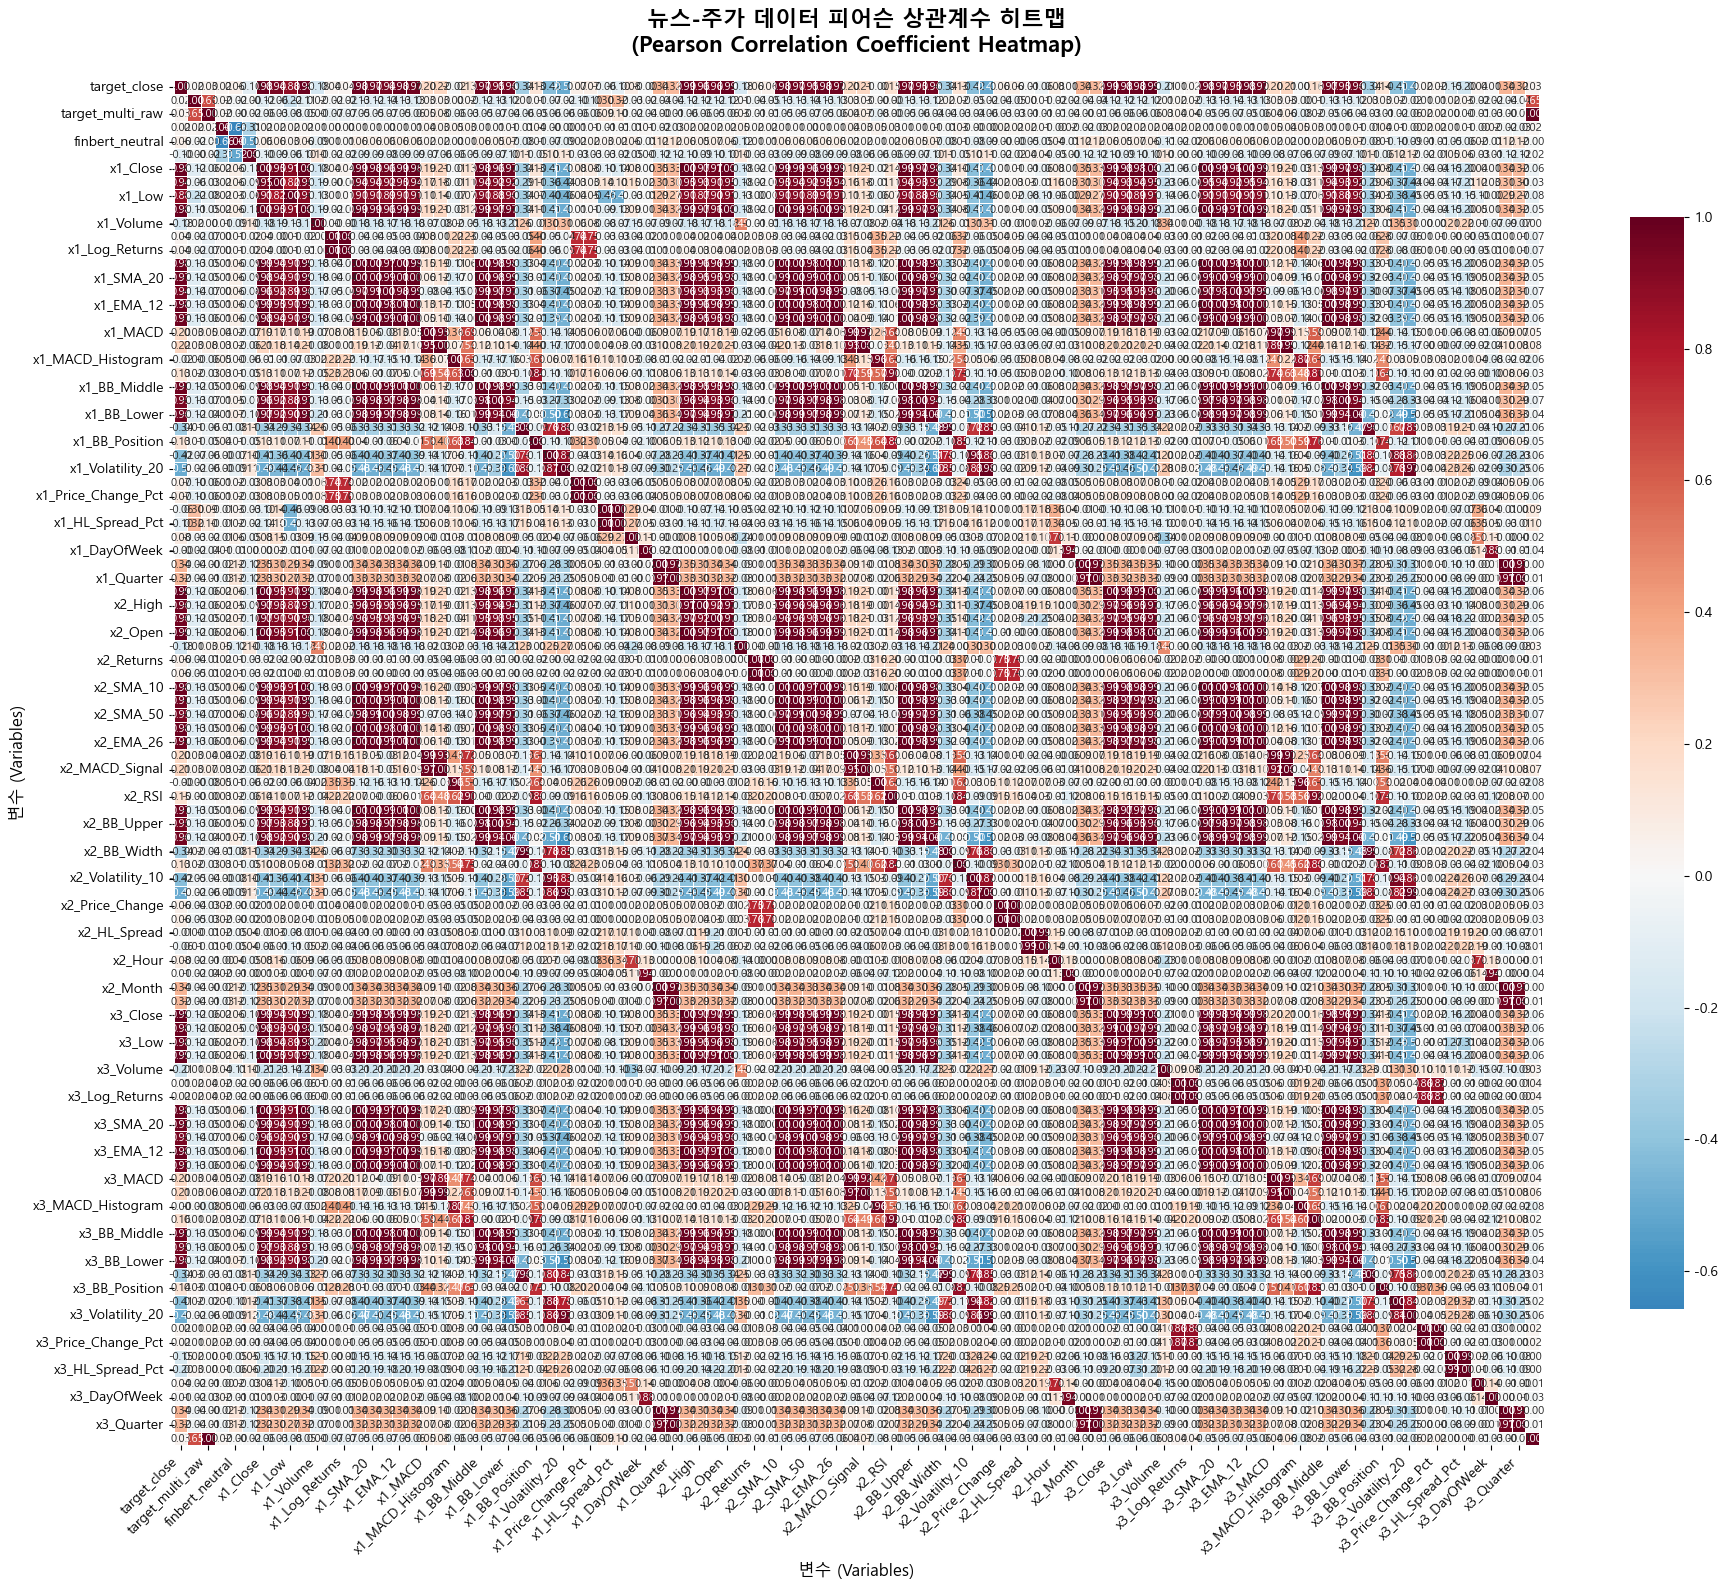


=== 타겟 변수(target_multi)와의 상관계수 (절댓값 기준 내림차순) ===
target_multi         1.000000
target_multi_raw     1.000000
target_return_pct    0.645595
x1_HL_Spread_Pct     0.100649
x1_HL_Spread         0.088997
x1_Low               0.081327
x2_MACD_Histogram    0.076569
x3_MACD_Histogram    0.076451
x1_MACD_Signal       0.075199
x1_Log_Returns       0.071881
x1_Returns           0.071051
x1_SMA_50            0.069196
x2_MACD_Signal       0.068994
x2_SMA_50            0.068784
x3_SMA_50            0.068264
x1_BB_Upper          0.065105
x3_MACD_Signal       0.062784
x2_BB_Upper          0.062595
x3_BB_Upper          0.060732
x1_MACD_Histogram    0.060351
Name: target_multi, dtype: float64

=== 높은 상관관계 변수 쌍 (|상관계수| >= 0.7) ===
총 778개 쌍 발견
           Variable_1    Variable_2  Correlation
752         x3_SMA_20  x3_BB_Middle     1.000000
564         x2_SMA_20  x2_BB_Middle     1.000000
210         x1_SMA_20  x1_BB_Middle     1.000000
36   target_multi_raw  target_multi     1.000000
248         x1_SMA_5

In [2]:
# 피어슨 상관계수(Pearson Correlation Coefficient) 기반 히트맵 시각화

# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 조작 및 분석용
import numpy as np  # 수치 계산용
import matplotlib.pyplot as plt  # 기본 플롯 생성용
import seaborn as sns  # 고급 통계 시각화용 (히트맵에 특화)

# 이전 셀에서 생성된 CSV 파일 불러오기
df = pd.read_csv("news_stock_classification.csv")  # 뉴스-주가 병합 데이터 로드

# 수치형 컬럼만 자동으로 선별 (상관계수는 수치형 데이터에만 적용 가능)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # int, float 타입 컬럼들만 추출

# 분석에 불필요한 ID 컬럼 제거 (ID는 식별용이므로 상관관계 분석에 부적절)
if 'news_id' in numeric_cols:  # news_id 컬럼이 존재하는지 확인
    numeric_cols.remove('news_id')  # 존재하면 제거 리스트에서 삭제

# 데이터 기본 정보 출력
print(f"분석할 수치형 변수 개수: {len(numeric_cols)}")  # 상관계수 분석에 사용할 변수 개수
print(f"데이터 크기: {df.shape}")  # 전체 데이터 크기 (행, 열)

# 피어슨 상관계수 매트릭스 계산
correlation_matrix = df[numeric_cols].corr()  # pandas의 corr() 함수로 모든 변수 간 상관계수 계산

# 히트맵 시각화를 위한 플롯 크기 설정
plt.figure(figsize=(20, 16))  # 매우 큰 캔버스 생성 (변수가 많을 때 가독성 확보)

# 한국어 폰트 설정 (제목과 레이블을 한국어로 표시하기 위함)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호(-) 깨짐 방지

# seaborn을 이용한 히트맵 생성 (상관계수 시각화에 최적화된 함수)
sns.heatmap(correlation_matrix,  # 상관계수 매트릭스 데이터
            annot=True,          # 각 셀에 상관계수 수치 표시
            cmap='RdBu_r',       # 색상 팔레트: 빨강(음의 상관)-흰색(0)-파랑(양의 상관)
            center=0,            # 0을 색상 중심으로 설정 (중립적 색상 배치)
            square=True,         # 각 셀을 정사각형으로 만들어 균등한 비율 유지
            linewidths=0.5,      # 셀 간 경계선 두께 설정 (구분 명확화)
            cbar_kws={"shrink": .8},  # 컬러바(범례) 크기를 80%로 축소
            fmt='.2f',           # 상관계수를 소수점 둘째 자리까지 표시
            annot_kws={'size': 8})  # 셀 내 텍스트 크기 설정

# 플롯 제목 및 축 레이블 설정
plt.title('뉴스-주가 데이터 피어슨 상관계수 히트맵\n(Pearson Correlation Coefficient Heatmap)',  # 이중 제목
          fontsize=16, fontweight='bold', pad=20)  # 폰트 크기, 굵기, 여백 설정
plt.xlabel('변수 (Variables)', fontsize=12)  # x축 레이블
plt.ylabel('변수 (Variables)', fontsize=12)  # y축 레이블

# 축 레이블 회전 및 정렬 (변수명이 길 때 가독성 향상)
plt.xticks(rotation=45, ha='right')  # x축 레이블을 45도 회전, 오른쪽 정렬
plt.yticks(rotation=0)  # y축 레이블은 수평 유지

# 레이아웃 자동 조정 (제목, 레이블이 겹치지 않도록)
plt.tight_layout()  # 플롯 요소들이 캔버스에 최적으로 배치되도록 조정
plt.show()  # 히트맵 출력

# =============================================================================
# 상관관계 분석 섹션

# 타겟 변수와 다른 모든 변수들의 상관관계 분석
target_corr = correlation_matrix['target_multi'].abs().sort_values(ascending=False)  # target_multi와의 상관계수 절댓값으로 정렬
print("\n=== 타겟 변수(target_multi)와의 상관계수 (절댓값 기준 내림차순) ===")
print(target_corr.head(20))  # 상위 20개 변수의 상관계수 출력

# 높은 상관관계를 가진 변수 쌍 탐지 함수 정의
def find_high_correlations(corr_matrix, threshold=0.7):
    """
    상관계수 매트릭스에서 임계값 이상의 높은 상관관계를 가진 변수 쌍을 찾는 함수
    Args:
        corr_matrix: 상관계수 매트릭스
        threshold: 임계값 (기본 0.7, 즉 70% 이상 상관관계)
    Returns:
        높은 상관관계 변수 쌍들의 DataFrame
    """
    high_corr_pairs = []  # 높은 상관관계 쌍들을 저장할 리스트
    
    # 상관계수 매트릭스의 상삼각형 부분만 순회 (중복 제거)
    for i in range(len(corr_matrix.columns)):  # 첫 번째 변수 인덱스
        for j in range(i+1, len(corr_matrix.columns)):  # 두 번째 변수 인덱스 (i+1부터 시작하여 중복 방지)
            corr_value = abs(corr_matrix.iloc[i, j])  # 상관계수의 절댓값
            if corr_value >= threshold:  # 임계값 이상인 경우
                high_corr_pairs.append({  # 딕셔너리 형태로 저장
                    'Variable_1': corr_matrix.columns[i],  # 첫 번째 변수명
                    'Variable_2': corr_matrix.columns[j],  # 두 번째 변수명
                    'Correlation': corr_matrix.iloc[i, j]  # 실제 상관계수 값 (음수 포함)
                })
    
    # DataFrame으로 변환 후 절댓값 기준으로 내림차순 정렬
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)

# 높은 상관관계 변수 쌍 탐지 실행
high_corr_df = find_high_correlations(correlation_matrix, threshold=0.7)  # 0.7 이상 상관관계 탐지
print(f"\n=== 높은 상관관계 변수 쌍 (|상관계수| >= 0.7) ===")
print(f"총 {len(high_corr_df)}개 쌍 발견")  # 발견된 쌍의 개수
if len(high_corr_df) > 0:  # 높은 상관관계 쌍이 존재하는 경우
    print(high_corr_df.head(15))  # 상위 15개 쌍 출력

# FinBERT 감정 점수와 타겟 변수의 상관관계 별도 분석
finbert_cols = [col for col in df.columns if 'finbert' in col.lower()]  # 'finbert'가 포함된 컬럼명 추출
if finbert_cols:  # FinBERT 관련 컬럼이 존재하는 경우
    print(f"\n=== FinBERT 감정 점수와 타겟의 상관관계 ===")
    for col in finbert_cols:  # 각 FinBERT 컬럼에 대해
        corr_val = correlation_matrix.loc['target_multi', col]  # 타겟과의 상관계수 추출
        print(f"{col}: {corr_val:.4f}")  # 소수점 넷째 자리까지 출력

# 상관계수 매트릭스의 전반적인 통계 정보
print(f"\n=== 상관계수 매트릭스 기본 정보 ===")
print(f"변수 개수: {correlation_matrix.shape[0]}")  # 매트릭스 크기 (변수 개수)
# 대각선 제외한 최대 상관계수 (자기 자신과의 상관계수 1.0 제외)
print(f"최대 상관계수: {correlation_matrix.values[correlation_matrix.values < 1].max():.4f}")
print(f"최소 상관계수: {correlation_matrix.values.min():.4f}")  # 최소 상관계수
# 대각선 제외한 평균 절댓값 상관계수 (전체적인 상관관계 강도 파악)
print(f"평균 절댓값 상관계수: {np.abs(correlation_matrix.values[correlation_matrix.values < 1]).mean():.4f}")

In [3]:
# LSTM 기반 주가 방향 예측 모델 (딥러닝 시계열 분류)

# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 조작용
import numpy as np  # 수치 계산용
import torch  # PyTorch 딥러닝 프레임워크
from torch import nn  # 신경망 모듈들
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로더 및 텐서 데이터셋
from sklearn.model_selection import train_test_split  # 훈련/테스트 데이터 분리
from sklearn.preprocessing import StandardScaler  # 데이터 정규화
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # 평가 지표

# 1. 데이터 불러오기
df = pd.read_csv("news_stock_classification.csv", parse_dates=["news_time"])  # CSV 파일 로드, news_time을 날짜 타입으로 파싱

# 2. Feature 및 Label 준비
# 시계열 특성(x로 시작)과 감정 특성(finbert_로 시작)만 선별
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("finbert_")]  # x1_Open, x2_High, finbert_positive 등
X = df[feature_cols].fillna(0)  # 결측값을 0으로 채움 (주가 데이터에는 결측값이 거의 없음)
y = df["target_multi"]  # 타겟 변수 (0: 하락, 1: 보합, 2: 상승)

# 3. 시계열 데이터 3-step 시퀀스 생성 (LSTM 입력 형태로 변환)
X_seq = []  # 시퀀스 데이터를 담을 리스트
for i in range(len(X)):  # 각 샘플(뉴스)에 대해
    # 과거 3시점의 주가 데이터를 시간 순서대로 배열
    X_seq.append([
        X.iloc[i][[col for col in X.columns if col.startswith("x1_")]].values,  # 가장 오래된 시점 (t-2)
        X.iloc[i][[col for col in X.columns if col.startswith("x2_")]].values,  # 중간 시점 (t-1)  
        X.iloc[i][[col for col in X.columns if col.startswith("x3_")]].values   # 가장 최근 시점 (t)
    ])
X_seq = np.array(X_seq)  # 리스트를 numpy 배열로 변환 -> shape: (samples, time_steps, features)

# 4. FinBERT 감정 피처를 시계열 데이터에 추가
finbert_feats = X[[c for c in X.columns if c.startswith("finbert_")]].values  # FinBERT 감정 점수들만 추출
# FinBERT 점수를 각 시점마다 복사하여 시계열 형태로 변환 (뉴스 감정은 모든 시점에서 동일)
finbert_feats = np.repeat(finbert_feats[:, np.newaxis, :], 3, axis=1)  # shape: (samples, 3, finbert_features)
# 주가 시계열 데이터와 감정 데이터를 결합
X_seq = np.concatenate([X_seq, finbert_feats], axis=-1)  # 마지막 차원(특성 차원)에서 결합

# 5. 데이터 정규화 (LSTM 학습 안정성을 위해 필수)
n_samples, time_steps, n_features = X_seq.shape  # 데이터 차원 정보 추출
X_reshaped = X_seq.reshape(-1, n_features)  # 2D로 변환하여 StandardScaler 적용 가능하게 함
scaler = StandardScaler()  # 평균 0, 표준편차 1로 정규화하는 스케일러
X_scaled = scaler.fit_transform(X_reshaped)  # 정규화 적용 (fit: 통계량 계산, transform: 변환)
X_seq = X_scaled.reshape(n_samples, time_steps, n_features)  # 다시 3D 시계열 형태로 복원

# 6. PyTorch Tensor로 변환 (GPU 연산 및 자동 미분을 위해)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # 입력 데이터를 float32 텐서로 변환
y_tensor = torch.tensor(y.values, dtype=torch.long)  # 라벨을 long 타입 텐서로 변환 (분류용)

# 7. 훈련/테스트 데이터 분리
# shuffle=False: 시계열 데이터의 시간 순서 보존 (과거 데이터로 훈련, 미래 데이터로 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)
# DataLoader: 미니배치 학습을 위한 데이터 로더 생성
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)  # 훈련용: 셔플 ON
test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=32)  # 테스트용: 셔플 OFF

# 8. LSTM 분류 모델 클래스 정의
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        """
        LSTM 기반 분류 모델
        Args:
            input_dim: 입력 특성 차원 수
            hidden_dim: LSTM 은닉층 크기 (기본 64)
            output_dim: 출력 클래스 수 (3: 하락/보합/상승)
        """
        super().__init__()  # 부모 클래스 초기화
        # LSTM 레이어: 시계열 패턴을 학습하는 순환신경망
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)  # batch_first=True: (batch, seq, feature) 순서
        # 완전연결층: LSTM 출력을 분류 결과로 변환
        self.fc = nn.Linear(hidden_dim, output_dim)  # hidden_dim -> 3개 클래스

    def forward(self, x):
        """
        순전파 함수: 입력 데이터가 모델을 통과하는 과정
        Args:
            x: 입력 시계열 데이터 (batch_size, time_steps, features)
        Returns:
            분류 예측 결과 (batch_size, output_dim)
        """
        # LSTM 통과: output과 (hidden_state, cell_state) 반환
        _, (hn, _) = self.lstm(x)  # output은 사용하지 않음, 마지막 hidden state만 사용
        # 마지막 시점의 hidden state를 완전연결층에 입력
        return self.fc(hn[-1])  # hn[-1]: 마지막 LSTM 레이어의 마지막 시점 hidden state

# 9. 학습 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 가능하면 GPU, 아니면 CPU
model = LSTMClassifier(input_dim=n_features).to(device)  # 모델 생성 후 디바이스로 이동
loss_fn = nn.CrossEntropyLoss()  # 다중분류용 손실함수 (소프트맥스 + 음의 로그 우도)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기 (학습률 0.001)

# 10. 모델 학습 루프
for epoch in range(50):  # 50 에포크 학습
    model.train()  # 모델을 훈련 모드로 설정 (드롭아웃, 배치정규화 활성화)
    total_loss = 0  # 에포크별 총 손실 초기화
    
    # 미니배치별 학습
    for xb, yb in train_dl:  # 훈련 데이터 로더에서 미니배치 가져오기
        xb, yb = xb.to(device), yb.to(device)  # 데이터를 GPU/CPU로 이동
        pred = model(xb)  # 순전파: 예측 결과 계산
        loss = loss_fn(pred, yb)  # 손실 계산 (예측값 vs 실제값)
        
        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()  # 이전 그래디언트 초기화 (PyTorch는 그래디언트 누적)
        loss.backward()  # 역전파: 그래디언트 계산
        optimizer.step()  # 가중치 업데이트
        
        total_loss += loss.item()  # 배치 손실을 총 손실에 누적
    
    # 에포크별 평균 손실 출력
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")  # 소수점 넷째 자리까지 출력

Epoch 1 | Loss: 164.3477
Epoch 2 | Loss: 139.6796
Epoch 3 | Loss: 124.8501
Epoch 4 | Loss: 111.8443
Epoch 5 | Loss: 101.0549
Epoch 6 | Loss: 92.1571
Epoch 7 | Loss: 83.2030
Epoch 8 | Loss: 75.8383
Epoch 9 | Loss: 68.7741
Epoch 10 | Loss: 62.8797
Epoch 11 | Loss: 57.9461
Epoch 12 | Loss: 53.7714
Epoch 13 | Loss: 49.2447
Epoch 14 | Loss: 45.3295
Epoch 15 | Loss: 42.6119
Epoch 16 | Loss: 38.7909
Epoch 17 | Loss: 36.0298
Epoch 18 | Loss: 32.7814
Epoch 19 | Loss: 30.8657
Epoch 20 | Loss: 27.9583
Epoch 21 | Loss: 25.6255
Epoch 22 | Loss: 23.7321
Epoch 23 | Loss: 22.0693
Epoch 24 | Loss: 19.8867
Epoch 25 | Loss: 18.5805
Epoch 26 | Loss: 16.9658
Epoch 27 | Loss: 15.2749
Epoch 28 | Loss: 13.7869
Epoch 29 | Loss: 13.3662
Epoch 30 | Loss: 11.6116
Epoch 31 | Loss: 11.0286
Epoch 32 | Loss: 10.0281
Epoch 33 | Loss: 9.0366
Epoch 34 | Loss: 8.1014
Epoch 35 | Loss: 7.6842
Epoch 36 | Loss: 6.8916
Epoch 37 | Loss: 6.2356
Epoch 38 | Loss: 5.4702
Epoch 39 | Loss: 5.1143
Epoch 40 | Loss: 4.6416
Epoch 41 | L

In [4]:
# 11. 평가
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n Accuracy:", accuracy_score(all_labels, all_preds))
print("\n Classification Report:\n", classification_report(all_labels, all_preds))


 Accuracy: 0.5975538730343622

 Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.34      0.27       246
           1       0.77      0.75      0.76      1224
           2       0.20      0.12      0.15       247

    accuracy                           0.60      1717
   macro avg       0.40      0.40      0.39      1717
weighted avg       0.61      0.60      0.60      1717



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import lightgbm as lgb

# 1. 데이터 불러오기
df = pd.read_csv("news_stock_classification.csv", parse_dates=["news_time"])

# 2. Feature 및 Label 준비
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("finbert_")]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test 분리 (LSTM 방식 그대로)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# 5. LightGBM 모델 및 GridSearchCV 세팅
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [3, 5]
}

# f1_macro로 평가
grid = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,           
    verbose=1,
    n_jobs=-1
)

# 6. 학습
grid.fit(X_train, y_train)   

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21520
[LightGBM] [Info] Number of data points in the train set: 6867, number of used features: 96
[LightGBM] [Info] Start training from score -1.823269
[LightGBM] [Info] Start training from score -0.364171
[LightGBM] [Info] Start training from score -1.939813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

GridSearchCV(cv=3,
             estimator=LGBMClassifier(num_class=3, objective='multiclass',
                                      random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 300]},
             scoring='f1_macro', verbose=1)

In [2]:
# 7. 평가
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(" Best Params:", grid.best_params_)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Macro F1-score:", f1_score(y_test, y_pred, average="macro"))
print("\n Classification Report:\n", classification_report(y_test, y_pred)) 

 Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
 Accuracy: 0.7169481654047758
 Macro F1-score: 0.2968467606472327

 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.72      1.00      0.84      1224
           2       0.70      0.03      0.05       247

    accuracy                           0.72      1717
   macro avg       0.47      0.34      0.30      1717
weighted avg       0.61      0.72      0.60      1717



c:\Users\jhh33\anaconda3\envs\pythonProject1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# 피쳐 줄이기

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. 데이터 불러오기
df = pd.read_csv("news_stock_classification.csv", parse_dates=["news_time"])

# 2. Feature 및 Label 준비
allowed_features = ["Open", "High", "Low", "Close", "Volume"]
feature_cols = [
    col for col in df.columns
    if (
        any(col.startswith(f"x{i}_") and any(f in col for f in allowed_features) for i in range(1, 4))
        or col.startswith("finbert_")
    )
]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 3. 시계열 데이터 3-step 시퀀스 생성 (LSTM 입력 형태로 변환)
X_seq = []
for i in range(len(X)):
    X_seq.append([
        X.iloc[i][[col for col in X.columns if col.startswith("x1_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x2_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x3_")]].values
    ])
X_seq = np.array(X_seq)

# 4. FinBERT 감정 피처를 시계열 데이터에 추가
finbert_feats = X[[c for c in X.columns if c.startswith("finbert_")]].values
finbert_feats = np.repeat(finbert_feats[:, np.newaxis, :], 3, axis=1)
X_seq = np.concatenate([X_seq, finbert_feats], axis=-1)

# 5. 데이터 정규화
n_samples, time_steps, n_features = X_seq.shape
X_reshaped = X_seq.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_seq = X_scaled.reshape(n_samples, time_steps, n_features)

# 6. Tensor로 변환
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# 7. Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# 8. LSTM 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# 9. 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_dim=n_features).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10. 학습 루프
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 180.7613
Epoch 2 | Loss: 169.1933
Epoch 3 | Loss: 166.0440
Epoch 4 | Loss: 164.4296
Epoch 5 | Loss: 162.7448
Epoch 6 | Loss: 161.7328
Epoch 7 | Loss: 160.6223
Epoch 8 | Loss: 158.9649
Epoch 9 | Loss: 157.8134
Epoch 10 | Loss: 157.2454
Epoch 11 | Loss: 156.1486
Epoch 12 | Loss: 155.2985
Epoch 13 | Loss: 154.5000
Epoch 14 | Loss: 154.0425
Epoch 15 | Loss: 153.2232
Epoch 16 | Loss: 152.7776
Epoch 17 | Loss: 151.0857
Epoch 18 | Loss: 150.4962
Epoch 19 | Loss: 149.7166
Epoch 20 | Loss: 148.6844
Epoch 21 | Loss: 147.5555
Epoch 22 | Loss: 146.7276
Epoch 23 | Loss: 145.7051
Epoch 24 | Loss: 145.0382
Epoch 25 | Loss: 143.6247
Epoch 26 | Loss: 142.1871
Epoch 27 | Loss: 141.5608
Epoch 28 | Loss: 140.2505
Epoch 29 | Loss: 138.9848
Epoch 30 | Loss: 137.6334
Epoch 31 | Loss: 136.5103
Epoch 32 | Loss: 135.2246
Epoch 33 | Loss: 133.4288
Epoch 34 | Loss: 131.6238
Epoch 35 | Loss: 130.7769
Epoch 36 | Loss: 129.1905
Epoch 37 | Loss: 127.7258
Epoch 38 | Loss: 126.0988
Epoch 39 | Loss: 124.

In [4]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n Accuracy:", accuracy_score(all_labels, all_preds))
print("\n Classification Report:\n", classification_report(all_labels, all_preds))


 Accuracy: 0.6441467676179382

 Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.04      0.05       246
           1       0.72      0.88      0.79      1224
           2       0.36      0.10      0.15       247

    accuracy                           0.64      1717
   macro avg       0.38      0.34      0.33      1717
weighted avg       0.58      0.64      0.59      1717

